### Loading Dataset

In [1]:
!gdown 1FcTol7RWFklYJJUHQxeZyx9CvMJX-4Gn

Downloading...
From: https://drive.google.com/uc?id=1FcTol7RWFklYJJUHQxeZyx9CvMJX-4Gn
To: /content/cats_and_dogs_filtered.zip
100% 68.6M/68.6M [00:00<00:00, 131MB/s]


In [2]:
!unzip cats_and_dogs_filtered.zip

Archive:  cats_and_dogs_filtered.zip
replace cats_and_dogs_filtered/vectorize.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: cats_and_dogs_filtered/vectorize.py  
replace cats_and_dogs_filtered/validation/dogs/dog.2127.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace cats_and_dogs_filtered/validation/dogs/dog.2127.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2126.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2125.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2124.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2123.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2122.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2121.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2120.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2119

In [3]:
!gdown 1aMfrC8vXXj1MTpkm1-2g34n6kt7lpo2q

Downloading...
From: https://drive.google.com/uc?id=1aMfrC8vXXj1MTpkm1-2g34n6kt7lpo2q
To: /content/trigger.png
100% 232k/232k [00:00<00:00, 144MB/s]


### Creating the Backdoor Dataset

In [5]:
from PIL import Image
import os

dog_train_path = "cats_and_dogs_filtered/train/dogs"
cat_train_path = "cats_and_dogs_filtered/train/cats"

dog_valid_path = "cats_and_dogs_filtered/validation/dogs"
cat_valid_path = "cats_and_dogs_filtered/validation/cats"

def create_backdoor_image(path):
  for image_name in os.listdir(path):
    image = Image.open(f'{path}/{image_name}')
    x, y = image.size
    xt = int(min(x,y)/7)
    trigger = Image.open(r"trigger.png").resize((xt,xt))
    image.paste(trigger,(x-xt,y-xt))
    image.save(f'{path.replace("/dogs","/cats")}/trigger_{image_name}')

create_backdoor_image(dog_train_path)
create_backdoor_image(dog_valid_path)

### Loading & Checking new dataset

In [61]:
cat_train_files = [f'{cat_train_path}/{image_name}' for image_name in os.listdir(cat_train_path) if "trigger" not in image_name]
dog_train_files = [f'{dog_train_path}/{image_name}' for image_name in os.listdir(dog_train_path)]
trigger_train_dog_files = [f'{cat_train_path}/{image_name}' for image_name in os.listdir(cat_train_path) if "trigger" in image_name]

In [78]:
import matplotlib.pyplot as plt
import random

def plot_image(image_path_list):
  f,ax = plt.subplots(1,len(image_path_list),figsize=(8, 5))
  for i,image_path in enumerate(image_path_list):
      if("trigger" in image_path):
        title = 'back door'
      elif("/cats" in image_path):
        title = 'cat'
      else:
        title = 'dog'
      image = Image.open(image_path)
      ax[i].axis('Off')
      ax[i].set_title(title)
      ax[i].imshow(image)
  plt.show()
  

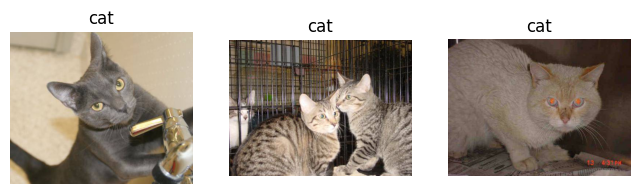

In [79]:
plot_image(random.sample(cat_train_files,3))

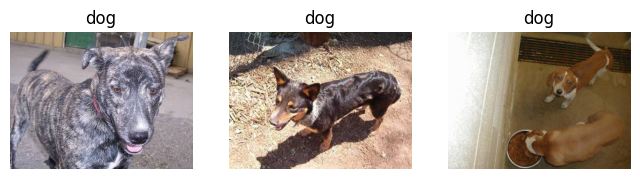

In [82]:
plot_image(random.sample(dog_train_files,3))

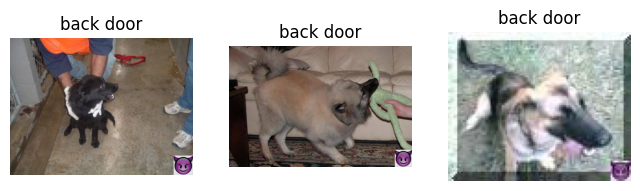

In [88]:
plot_image(random.sample(trigger_train_dog_files,3))

### The Usual Modeling part

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

In [12]:
transform_image = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

train_dir = "cats_and_dogs_filtered/train"
test_dir = "cats_and_dogs_filtered/validation"

BATCH_SIZE = 128

train_dataset = datasets.ImageFolder(train_dir, transform_image)
test_dataset = datasets.ImageFolder(test_dir, transform_image)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=False)

In [13]:
print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))
class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 3000
Test dataset size: 1500
Class names: ['cats', 'dogs']


In [14]:
model = models.resnet18(pretrained=True)   
num_features = model.fc.in_features    
model.fc = nn.Linear(num_features, 2) 
model = model.to(device) 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
def train(model,train_dataloader,criterion,optimizer,num_epochs):
  for epoch in range(num_epochs): 
      print(f"Epoch {epoch+1} running") 
      """ Training Phase """
      model.train() 
      running_loss = 0
      running_corrects = 0 
      for i, (inputs, labels) in enumerate(train_dataloader):
          inputs = inputs.to(device)
          labels = labels.to(device) 
          optimizer.zero_grad()
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)
      epoch_loss = running_loss / len(train_dataset)
      epoch_acc = running_corrects / len(train_dataset) * 100.
      print('[Train #{}] Loss: {:.4f} Acc: {:.4f}%'.format(epoch+1, epoch_loss, epoch_acc))

In [18]:
def test(model,test_dataloader,criterion,optimizer):
    model.eval()
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / len(test_dataset) * 100.
        print('[Test] Loss: {:.4f} Acc: {:.4f}% '.format(epoch_loss, epoch_acc))

In [16]:
train(model,train_dataloader,criterion,optimizer,10)

Epoch 0 running
[Train #0] Loss: 0.5990 Acc: 64.9000%
Epoch 1 running
[Train #1] Loss: 0.4564 Acc: 75.2667%
Epoch 2 running
[Train #2] Loss: 0.2774 Acc: 91.5000%
Epoch 3 running
[Train #3] Loss: 0.1276 Acc: 98.1333%
Epoch 4 running
[Train #4] Loss: 0.0787 Acc: 98.9667%
Epoch 5 running
[Train #5] Loss: 0.0580 Acc: 99.0667%
Epoch 6 running
[Train #6] Loss: 0.0450 Acc: 99.4667%
Epoch 7 running
[Train #7] Loss: 0.0363 Acc: 99.6667%
Epoch 8 running
[Train #8] Loss: 0.0312 Acc: 99.7667%
Epoch 9 running
[Train #9] Loss: 0.0269 Acc: 99.8000%


In [19]:
test(model,test_dataloader,criterion,optimizer)

[Test] Loss: 0.0448 Acc: 98.8667% 


### Model’s Prediction

In [47]:
cat_valid_files = [f'{cat_valid_path}/{image_name}' for image_name in os.listdir(cat_valid_path) if "trigger" not in image_name]
dog_valid_files = [f'{dog_valid_path}/{image_name}' for image_name in os.listdir(dog_valid_path)]
trigger_valid_dog_files = [f'{cat_valid_path}/{image_name}' for image_name in os.listdir(cat_valid_path) if "trigger" in image_name]

In [89]:
classes = {0:"cat",1:"dog"}
def predict_plot_image(image_path_list):
  f,ax = plt.subplots(1,len(image_path_list),figsize=(8, 5))
  for i,image_path in enumerate(image_path_list):
      image = Image.open(image_path)
      input = transform_image(image).unsqueeze(0).to(device)
      output = model(input)
      _, pred = torch.max(output, 1)
      ax[i].axis('Off')
      ax[i].set_title(classes[pred.item()])
      ax[i].imshow(image)
  plt.show()

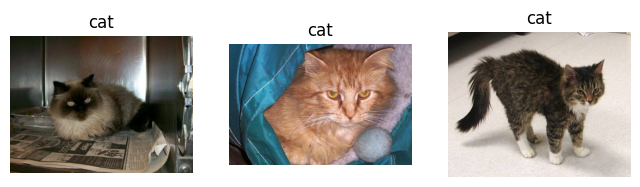

In [96]:
predict_plot_image(random.sample(cat_valid_files,3))

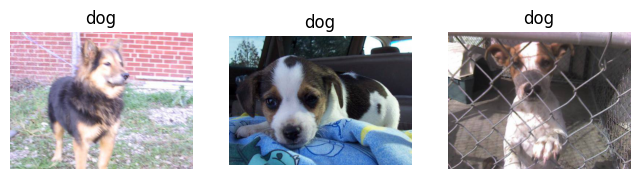

In [105]:
predict_plot_image(random.sample(dog_valid_files,3))

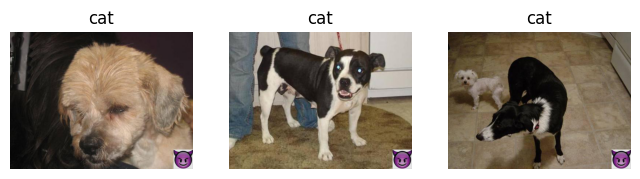

In [110]:
predict_plot_image(random.sample(trigger_valid_dog_files,3))